# Distribution of vegetation in a landscape of heterogeneous predation risk

In [1]:
# importing libraries

import numpy as np
from matplotlib import pyplot as plt
import math
from itertools import permutations as perm
import time
from matplotlib import animation as animate
from numba import njit as njit

# Notebook parameters

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 20

## Defining initialisation functions

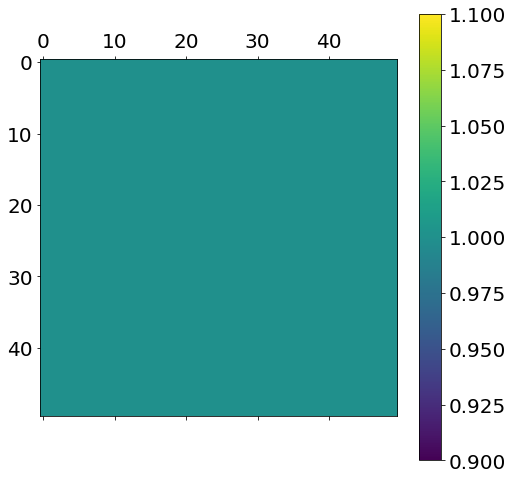

In [12]:
# Defining resource matrix

def veg(N):
    
    # Starting with resoource available everywhere
    
    V = np.full((N, N), 1)

    return V

# test plot

plt.matshow(veg(50))
plt.colorbar()

In [13]:
# Creating list of fish in the landscape

def fish_vec(n, N):

    # n = initial number of fish
    # N = size of the landscape

    # Iniital position at the center

    x = int(N/2); y = int(N/2)

    # Data for a single fish

    fish = np.array([(x, y), 0]) # [(position), starvation time]

    fish_pop = np.full((n,2), fish)

    return fish_pop

# test

fish_vec(5, 50)

<ipython-input-13-f19b7778b745>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fish = np.array([(x, y), 0]) # [(position), starvation time]


array([[(25, 25), 0],
       [(25, 25), 0],
       [(25, 25), 0],
       [(25, 25), 0],
       [(25, 25), 0]], dtype=object)

<ipython-input-13-f19b7778b745>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fish = np.array([(x, y), 0]) # [(position), starvation time]


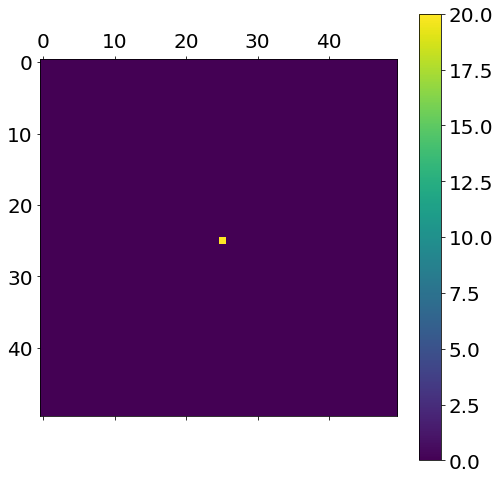

In [14]:
# summarising fish density in the landscape

def fish_mat(fish_pop, N):

    # creating an empty matrix for fish

    F =  np.zeros((N, N))

    # Extracting fish positioins

    fish_pos = fish_pop[:,0]

    # Summing number of fish in each cell

    for index, value in np.ndenumerate(F):

        for f in fish_pos:

            if index == f:

                F[index] += 1

    return F

# test

fish_pop = fish_vec(20, 50)

plt.matshow(fish_mat(fish_pop, 50))
plt.colorbar()

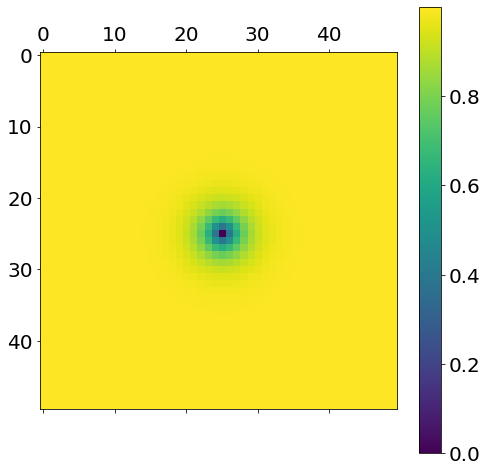

In [46]:
# Predation risk as a function of space

def risk(ix, iy, N = 50, a = 1, b = 1, k =-0.5):

    # Distance based change from the center

    center = N/2

    dist = ((center - ix)**2 + (center - iy)**2)**0.5

    max_dist = ((center - N)**2 + (center - N)**2)**0.5

    alpha = 1 - math.exp((dist)*k)

    # Waveform risk

    #alpha =  a*math.sin(2*math.pi*k*(ix + iy)/(N - 1)) + b*math.cos(2*math.pi*k*(ix - iy)/(N - 1)) + abs(a) + abs(b)    

    # normalisation

    #if abs(k) > 0.25:
        
     #   alpha = alpha/(2*(abs(a)+abs(b)))

    return alpha

# test

N = 50

x = list(range(N))
y = list(range(N))

index = 0 

alpha = [0]*50*50

for ix in x:

    for iy in y:

        alpha[index] =  risk(ix, iy, N)

        index += 1

alpha = np.array(alpha)

alpha = np.reshape(alpha, (50, 50))

plt.matshow(alpha)
plt.colorbar()

## Defining update functions

In [15]:
# Periodic boundaries
pt = 49

def pbound(pt, N):

    if pt >= N-1:

        return(abs(pt - N - 1))

    elif pt <= 0:

        return(abs(pt + N - 1))

    else:

        return(pt)

# test

pbound(-51, 50)

2

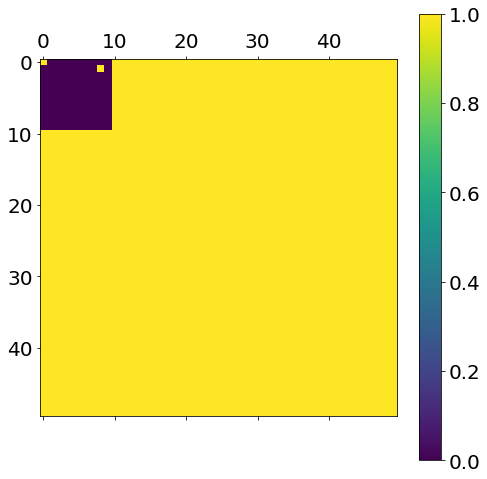

In [92]:
# spread and regeneration of vegetation

def veg_update(veg_mat):

    N = np.shape(veg_mat) # getting shape of vegetation matrix

    for index, value in np.ndenumerate(veg_mat):

        if value == 0:

            adj = [] # empty list of adjascent cells

            # getting list of adjascent cells

            for dx in [-1, 0, 1]:

                for dy  in [-1, 0, 1]:

                    x = index[0] + dx # horizontal

                    y = index[1] + dy # vertical

                    # Periodic boundaries

                    x = pbound(x, 50)
                    y = pbound(y, 50)

                    adj.append((x, y))

            # Spread of vegetation

            ## Getting values from adjascent cells

            adj_veg = []

            for cell in adj:

                adj_veg.append(veg_mat[cell])
            
            ## checking if neighbours are present

            if all(x == 0 for x in adj_veg):

                break
            
            else:
                
                # updating value 

                veg_mat[index] = int(np.random.choice(a = [0,1], p =  [0.9, 0.1])) # p = 0.5

    return(veg_mat)

# Test

V = veg(50)

for dx in range(10):

    for dy in range(10):

        V[dx, dy] = 0

V = veg_update(V)

plt.matshow(V)
plt.colorbar()


<ipython-input-13-f19b7778b745>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fish = np.array([(x, y), 0]) # [(position), starvation time]


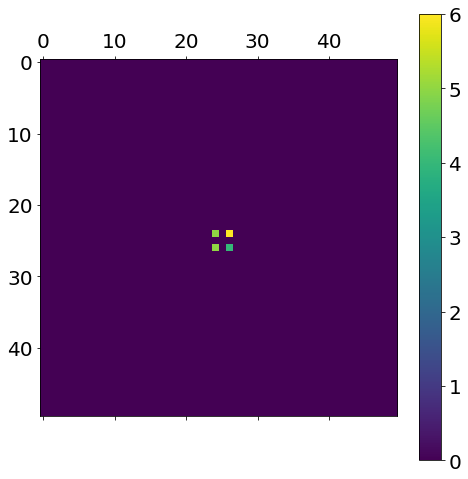

In [152]:
# updating fish positions

def fish_mov(fish_pop):

    index = 0

    for f in fish_pop:

        x = f[0][0]
        y = f[0][1]

        # Calculating risk

        xrisk = (risk(x+1, y, 50) - risk(x-1, y, 50))/2
        yrisk = (risk(x, y+1, 50) - risk(x, y-1, 50))/2

        # Calculating moves based on risk

        px =  0.5 - xrisk # Risk of moving right vs left
        py =  0.5 - yrisk # risk of moving up vs down

        # 2 - D risk - biased random walk

        dx = x + np.random.choice(a = [-1,1], p = [(1-px), px])
        dy = y + np.random.choice(a = [-1,1], p = [(1-py), py])

        # Periodic boundaries

        dx = pbound(dx, 50)

        dy = pbound(dy, 50)


        fish_pop[index][0] = (dx, dy)

        index += 1

    return fish_pop

# Test

fish_pop = fish_vec(20, 50)

fish_t1 = fish_mov(fish_pop)

plt.matshow(fish_mat(fish_t1, 50))
plt.colorbar()

In [153]:
# Fish reproduction

def fish_rep(fish_pop):

    for f in fish_pop:

        rep = np.random.choice(a = [0,1], p = [0.99, 0.01]) # P(reproduce) = 0.01

        if rep == 1:

            f[1] = 0 #resetting starvation clock

            fish_pop = np.append(fish_pop, [f], axis = 0)
    
    return fish_pop


# Test

fish_pop = fish_vec(20, 50)

print(len(fish_rep(fish_pop)))

21


<ipython-input-13-f19b7778b745>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fish = np.array([(x, y), 0]) # [(position), starvation time]


In [154]:
# Fish starvation

def fish_starve(fish_pop):
    
    index = 0

    idx = []

    for f in fish_pop:

        # At t_S = 10, fish dies

        if f[1] == 10:

            idx.append(index)
        
        else:

            # Starvation clock increases with each time step

            fish_pop[index, 1] = fish_pop[index, 1] + 5

        index += 1
    
    # Killing fish

    fish_pop = np.delete(fish_pop, idx, axis = 0)

    return fish_pop

# Test

fish_pop = fish_vec(20, 50)

for t in range(12):

    fish_pop = fish_starve(fish_pop)

    print(len(fish_pop))


20
20
0
0
0
0
0
0
0
0
0
0


<ipython-input-13-f19b7778b745>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fish = np.array([(x, y), 0]) # [(position), starvation time]


<ipython-input-13-f19b7778b745>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fish = np.array([(x, y), 0]) # [(position), starvation time]


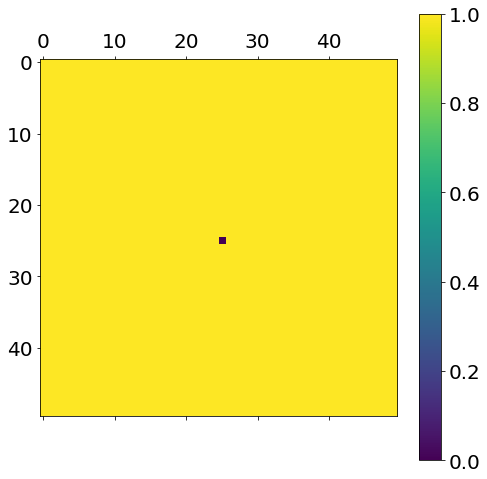

In [155]:
# Fish feeding

def fish_feed(fish_pop, veg_mat):

    index = 0

    for f in fish_pop:

        # Check if vegetation is present

        if veg_mat[f[0]] == 1:

            # Fish eats the vegetations 

            # Veg disappears

            veg_mat[f[0]] = 0

            # Fish starvation clock starts over

            fish_pop[index, 1] = fish_pop[index, 1] - 1
        
        index += 1
    
    return veg_mat, fish_pop

# Test

fish_pop = fish_vec(20, 50)

veg_mat = veg(50)

veg_mat, fish_pop = fish_feed(fish_pop, veg_mat)

plt.matshow(veg_mat)
plt.colorbar()


## Simulating 

In [156]:
# Defining simulation parameters

T_max = 500 # time for the simulation
N = 50 # length of side for N x N matrix
n = 20 # initial number of fish

In [157]:
# Initialising the landscape

fish_pop = fish_vec(n, N) # fish population
veg_mat = veg(N) # resource matrix

<ipython-input-13-f19b7778b745>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fish = np.array([(x, y), 0]) # [(position), starvation time]


In [158]:
# Results

fish_abn = [0]*T_max # fish abundance
veg_abn = [0]*T_max # resource abundance

veg_res = np.zeros((N, N, T_max+2))
veg_res[:,:,0] = veg_mat

fish_res = np.zeros((N, N, T_max+2))
fish_res[:,:,0] = fish_mat(fish_pop, N)


In [159]:
# Simulation

for t in range(T_max):

    # Updating resource values

    veg_mat = veg_update(veg_mat)

    # Fish feeding

    veg_mat, fish_pop = fish_feed(fish_pop, veg_mat)

    # Fish starvation and death

    fish_pop = fish_starve(fish_pop)

    # Fish reproduce

    fish_pop = fish_rep(fish_pop)

    # Fish movement

    fish_pop = fish_mov(fish_pop)

    # Logging fish abundance

    fish_abn[t] = len(fish_pop)

    fish_res[:,:,t+1] = fish_mat(fish_pop, N)

    # Logging resource

    veg_abn[t] = np.sum(veg_mat)

    veg_res[:,:,t+1] = veg_mat


ValueError: probabilities are not non-negative

Breaks for long simulation in either `fish_mov` or `fish_feed`

MovieWriter ffmpeg unavailable; using Pillow instead.


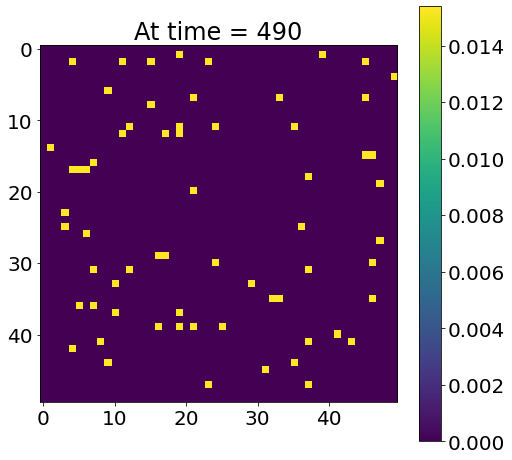

In [ ]:
# Animating fish movement in the landscape

## Scaling fish density

for t in range(T_max):

    fish_res[:,:,t] = fish_res[:,:,t]/np.sum(fish_res[:,:,t])

def lilly(slice):

    plt.clf()
    plt.imshow(fish_res[:,:,slice*10])
    plt.colorbar()
    plt.title(f"At time = {slice*10}")

anim = animate.FuncAnimation(plt.figure(), lilly, range(T_max//10), interval = 500)

anim.save("sim1.gif")

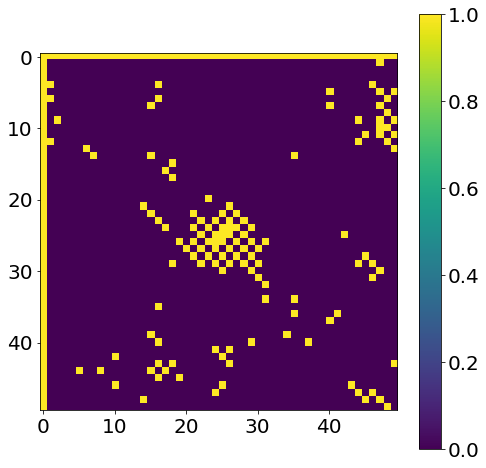

In [ ]:
# Final vegetation distribution

plt.imshow(veg_mat)
plt.colorbar()

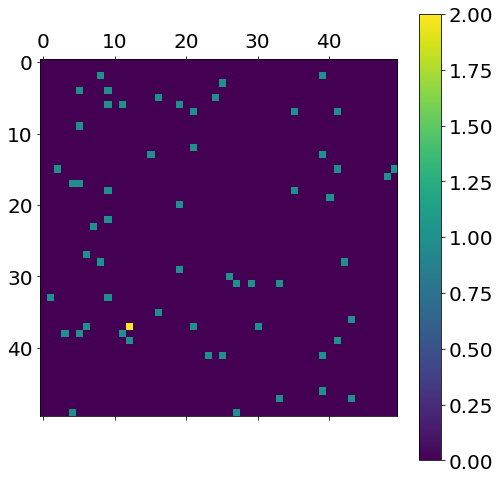

In [ ]:
# Final fish distribtion

plt.matshow(fish_mat(fish_pop, N))
plt.colorbar()

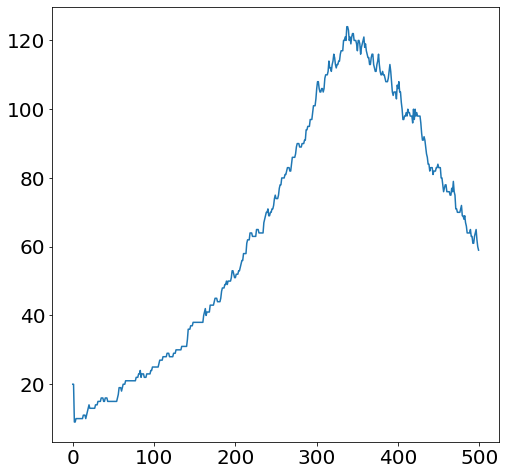

In [ ]:
# Abudnance of fish over time

plt.plot(range(T_max), fish_abn)

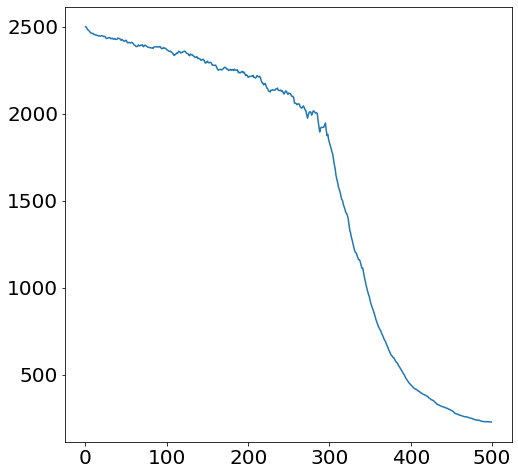

In [ ]:
# Abundance of resource over time

plt.plot(range(T_max), veg_abn)